# AGH Modelling of Physical Systems Lab 03 - assignment
Michał Szczygieł

We aim to analyze the impact of **dt** (temporal step) on the difference between the analytical and numerical solutions, examining the convergence of the solution for the advection equation solved using the upwind method. The error will be measured using the root mean square error (**RMSE**) between the numerical and analytical solutions. The analysis is conducted while ensuring that the physical setup and the Courant number remain unchanged.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from open_atmos_jupyter_utils import show_plot

To conduct this analysis, the `UpwindConvergenceAnalysis` class was created. Below is its definition, with detailed descriptions of the arguments it takes. This class is responsible for calculating the numerical solution for each **dt** in the range from **dt_step** to **dt_max**, adjusting **dx** accordingly to maintain a constant Courant number. The Gaussian distribution is generated by the class `Psi_0`.

In [ ]:
class Psi_0:
    def __init__(self):
        self.x0 = 5
        self.a = 1
        self.sigma = 25
    def __call__(self, x):
        return self.a * np.exp(-(x-self.x0)**2 / 2 / self.sigma**2)

class One:
    def __radd__(self, o):
        return slice(o.start + 1, o.stop + 1)
    def __rsub__(self, o):
        return slice(o.start - 1, o.stop - 1)

one = One()

def F(psi_l, psi_r, C):
    return (C + np.abs(C)) / 2 * psi_l + (C - np.abs(C)) / 2 * psi_r

def calc_upwind(psi: np.ndarray, nt: int, c: float, i: slice) -> np.ndarray:
    for _ in range(nt):
        psi[i] = psi[i] - (F(psi[i], psi[i + one], c) - F(psi[i - one], psi[i], c))
    return psi

def rmse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Computes the Root Mean Squared Error (RMSE) between true and predicted values.

    Args:
        y_true (np.ndarray): Array of true values.
        y_pred (np.ndarray): Array of predicted values.

    Returns:
        float: RMSE value.
    """
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

class UpwindConvergenceAnalysis:
    def __init__(self, u: float, c: float, x_min: float = -100, x_max: float = 300, t_max: float = 50, dt_min: float = .1, dt_step: float = .1, dt_max: float = 3):
        """
        Initialize the UpwindConvergenceAnalysis class.

        Args:
            u (float): Velocity.
            c (float): Courant number.
            x_min (float, optional): Minimum x value. Defaults to -100.
            x_max (float, optional): Maximum x value. Defaults to 300.
            t_max (float, optional): Maximum time value. Defaults to 50.
            dt_min (float, optional): Minimum time step. Defaults to 0.1.
            dt_step (float, optional): Time step increment. Defaults to 0.1.
            dt_max (float, optional): Maximum time step. Defaults to 3.
        """
        self.psi = Psi_0()

        self.c = c

        self.u = u
        self.x_min = x_min
        self.x_max = x_max

        self.t_max = t_max
        self.dt = np.arange(dt_min, dt_max, dt_step)

        self.errors = []

    def plot(self, fig: plt.Figure) -> None:
        """
        Plots the convergence analysis results on the given figure.

        Args:
            fig (plt.Figure): The figure to plot on.
        """
        fig.gca().plot(self.dt, np.array(self.errors), label=f'C={self.c:.1f}')

    def __run(self) -> 'UpwindConvergenceAnalysis':
        """
        Runs the upwind convergence analysis.

        Returns:
            UpwindConvergenceAnalysis: The instance of the class with updated errors
        """
        for dt in self.dt:
            nt = int(self.t_max / dt)

            dx = dt * self.u / self.c
            X = np.arange(self.x_min, self.x_max + 1, dx)
            nx = len(X)

            y_pred = calc_upwind(self.psi(X), nt, self.c, slice(1, nx-2))
            y_true = self.psi(X - self.u * self.t_max)

            self.errors.append(rmse(y_true, y_pred))

        return self

    def __call__(self):
        return self.__run()

In the analysis, the following parameters were used:

- Velocity: 4
- Simulation time: 50
- Four values of the Courant number: 0.2, 0.4, 0.6, 0.8
- **dt** in the range from 0.1 to 3, with a step size of 0.1
- **X** in the range from -100 to 300, with a step size equal to **dx**

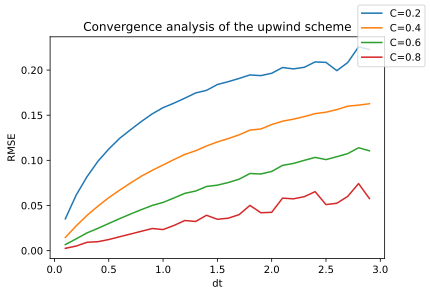

In [16]:
fig = plt.figure(figsize=(6, 4))
for i in range(1, 5):
    UpwindConvergenceAnalysis(3, i*0.2, t_max=50)().plot(fig)
fig.legend()
plt.xlabel('dt')
plt.ylabel('RMSE')
plt.title('Convergence analysis of the upwind scheme')
show_plot(fig=fig)


As observed, regardless of the Courant number, the smaller the **dt** (temporal step) was, the smaller the error became.